# Book Data Description

This notebook provides some basic descriptive stats for the GoodReads recommendation data from the [PIReT Book Data Tools](https://bookdata.piret.info), originally sourced from the [UCSD Book Graph](https://mengtingwan.github.io/data/goodreads).

I have saved a copy of this data to Tux, so you can access it from the [Tux Jupyterhub](https://support.cci.drexel.edu/cci-virtual-lab-resources/tux/tux-web-services-jupyterhub/).

## Setup

Let's get some libraries in here:

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

First, configure where to find the data.  If you are working on Tux, change this to `/site/courses/cs641/bookdata`.

In [4]:
bd_dir = Path('.')

We are going to load the **work actions** file: GoodReads add-to-shelf actions, aggregated by work.  This file is large; even when we limit the number of columns, it takes over 5GB of memory.

In [6]:
actions = pd.read_parquet(bd_dir / 'goodreads/full/gr-work-actions.parquet',
                          columns=['user', 'item', 'last_time', 'nactions', 'last_rating'])
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227029488 entries, 0 to 227029487
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user         int32  
 1   item         int32  
 2   last_time    int64  
 3   nactions     uint32 
 4   last_rating  float32
dtypes: float32(1), int32(2), int64(1), uint32(1)
memory usage: 5.1 GB


## Basic Data Statistics

We are going to start with basic statistics about the data set as a whole.  How many users and items do we have?

In [8]:
actions[['user', 'item']].nunique()

user     876145
item    1522486
dtype: int64

How many (user,item) pairs do we have observed actions for?

In [10]:
len(actions)

227029488

How many *actions* do we have, given that a user can add a book to more than one shelf?

In [11]:
actions['nactions'].sum()

229154523

How many (user, item) pairs do we have observed *ratings* for?

In [12]:
actions['last_rating'].count()

104029673

Finally, we want to compute the *density*: the fraction of (user,item) pairs for which we have observed interactions.  For the rest of this notebook, we will ignore repeated interactions and use the term 'action' for observing interactions from a user for an item.

In [13]:
n_users = actions['user'].nunique()
n_items = actions['item'].nunique()
n_actions = len(actions)
n_actions / (n_users * n_items)

0.00017019742105743108

We can also compute the *rating density*: the fraction with explicit rating values.

In [15]:
n_ratings = actions['last_rating'].count()
n_ratings / (n_users * n_items)

7.798802796070204e-05

## Item Statistics and Distributions

Let's compute some item statistics.  We'll start by computing the popularity in # of users adding each book:

In [18]:
item_counts = actions['item'].value_counts(sort=True, ascending=True).to_frame('user_count')
item_counts

,user_count
item,
440021811,1
457671674,1
448780967,1
421890546,1
402468870,1
...,...
400245494,244654
403212258,261917
403275794,285853


We can also compute rating statistics (# and mean):

In [21]:
item_rate_stats = actions.groupby('item')['last_rating'].agg(['count', 'mean']).rename(columns={'count': 'rating_count'})
item_stats = item_counts.join(item_rate_stats, how='left')
item_stats

,user_count,rating_count,mean
item,,,
440021811,1,1,4.000000
457671674,1,1,4.000000
448780967,1,1,4.000000
421890546,1,1,4.000000
402468870,1,1,3.000000
...,...,...,...
400245494,244654,181683,3.889115
403212258,261917,236150,3.361795
403275794,285853,208095,4.317009


Let's look at the popularity curve. We can draw a histogram, but it won't be helpful:

<Axes: ylabel='Frequency'>

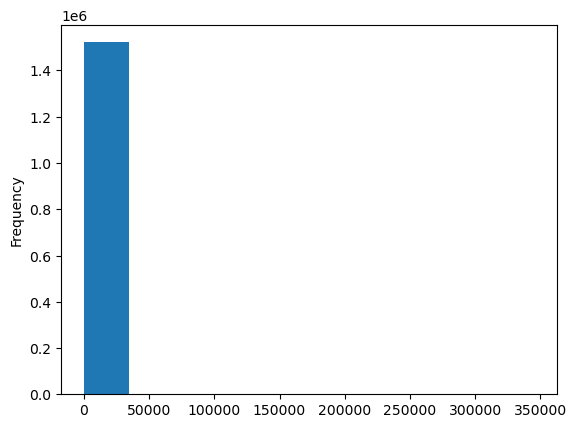

In [23]:
item_stats['user_count'].plot.hist()

This distribution is extremely skewed.  An easier way to look at it is a log-scaled *empirical cumulative distribution* plot, where the *x*-axis has the # of users for an item, and the *y*-axis has the **cumulative** fraction of items (fraction of items that have that many users or fewer).  The log scale makes the *x*-axis increase logarithmically, so the data is more readily visible when it is heavily skewed.

<Axes: xlabel='user_count', ylabel='Proportion'>

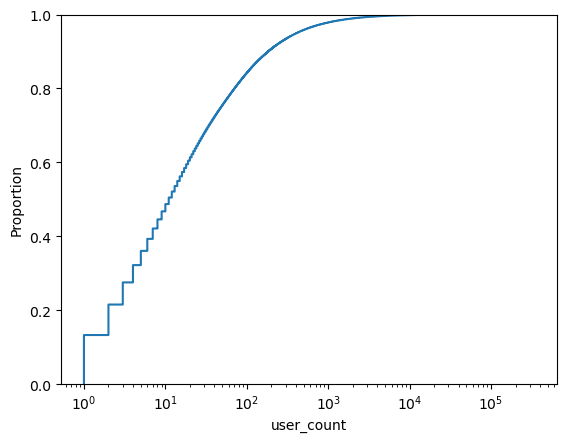

In [26]:
sns.ecdfplot(x=item_stats['user_count'], log_scale=True)

Another way to to visualize it is with a *Lorenz curve*.  This is like the CDF plot, except instead of putting the number of users on the *x*-axis, it sorts the data and plots it by rank from smallest to largest.  Since we already sorted our item statistics frame, we can do this with a cumulative sum.  We'll also plot a 45-degree line as a reference for what it would look like if every item had an equal number of interactions.

Text(0, 0.5, 'Cumulative Frac. of Actions')

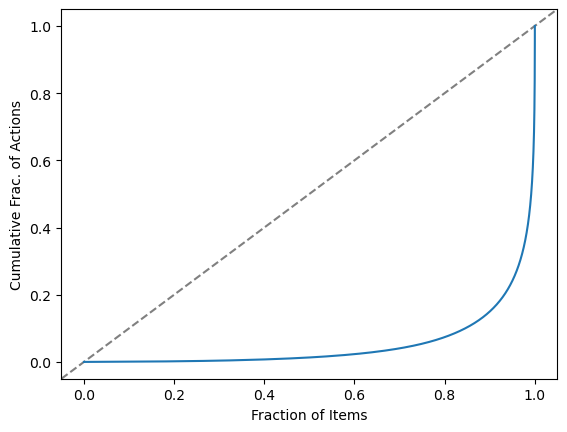

In [39]:
lc_cfrac = item_stats['user_count'].cumsum()
lc_cfrac /= n_actions

lc_rankfrac = np.arange(n_items) / n_items

plt.axline((0, 0), slope=1, color='grey', linestyle='dashed')
plt.plot(lc_rankfrac, lc_cfrac)
plt.xlabel('Fraction of Items')
plt.ylabel('Cumulative Frac. of Actions')

Since the curve is very low and to the right, we say that there is a very strong **popularity curve** in this data.

Lorenz curves are popular in economics, and are good for displaying how concentrated a resource (in this case, user interaction) is on a few items, vs. being distributed across the population.

## For You to Try

- Show the Lorenz curve of *ratings*
- Show the distribution of # of ratings per user (profile size) — a histogram or an ECDF are good for this, Lorenz curve makes less sense
- Show the distibution of item average ratings (histogram is a good choice)